<a href="https://colab.research.google.com/github/parth-pai/SOC23_Breakout_Genius/blob/main/SOC_Testing_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing all the required packages
!pip install gym
!pip install gym[atari]
!pip install gym[accept-rom-license]
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
#Importing necessary libraries
import random
import numpy as np
import torch
import torch.nn as nn
import gym
from scipy.signal import convolve, gaussian
from tqdm import trange

import os
import io
import base64
import time
import glob

from IPython.display import HTML
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Creating the environment
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack
from gym.wrappers import TransformReward

def make_env(env_name, clip_rewards=True, seed=None):
    env = gym.make(env_name)
    if seed is not None:
        env.seed(seed)
    env = AtariPreprocessing(env, screen_size=84, scale_obs=True)
    env = FrameStack(env, num_stack=4)
    if clip_rewards:
        env = TransformReward(env, lambda r: np.sign(r))
    return env

env_name = "BreakoutNoFrameskip-v4"
env = make_env(env_name)
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


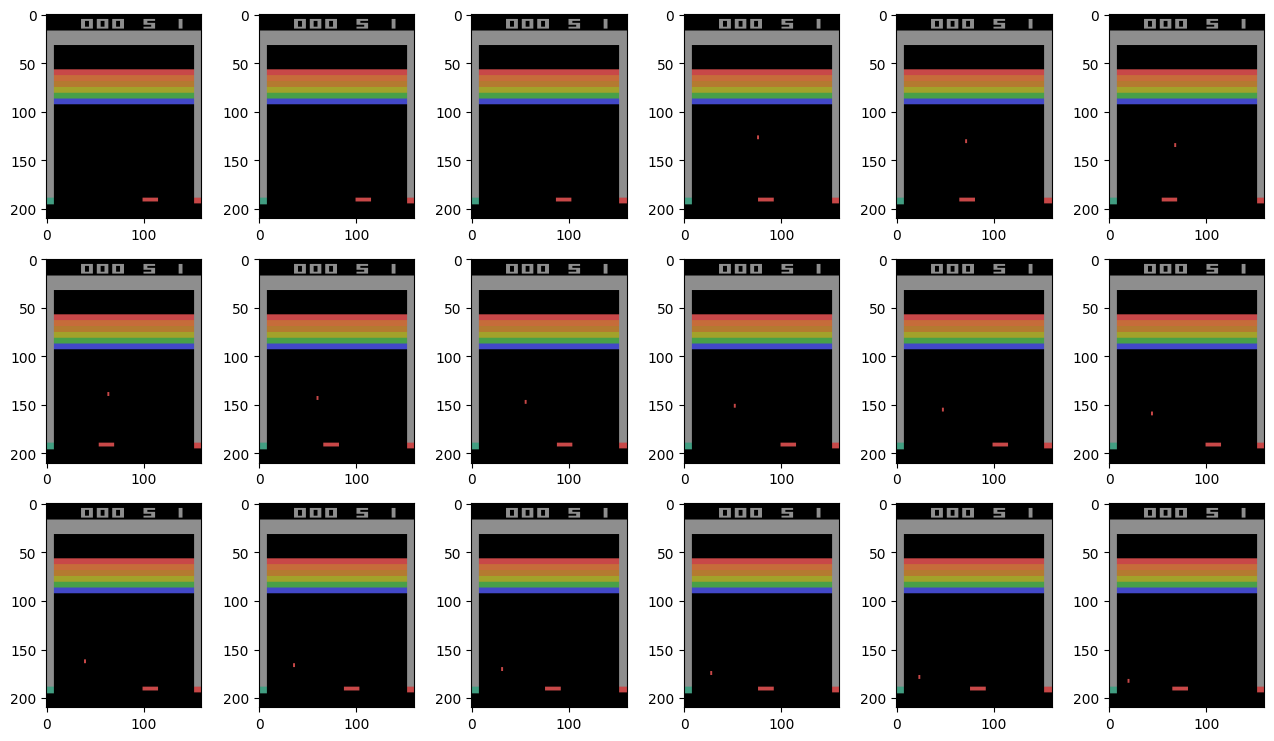

In [ ]:
#Getting sample images of the state
n_cols = 6
n_rows = 3
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

In [ ]:
n_actions
env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [ ]:
#Giving GPU access if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#Our main DQNAgent class
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon):
        super(DQNAgent,self).__init__()
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.state_shape = state_shape
        state_dim = state_shape[0]

        self.network = nn.Sequential()
        self.network.add_module('conv1', nn.Conv2d(4,16,kernel_size=8, stride=4))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('conv2', nn.Conv2d(16,32,kernel_size=4, stride=2))
        self.network.add_module('relu2', nn.ReLU())
        self.network.add_module('flatten', nn.Flatten())
        self.network.add_module('linear3', nn.Linear(2592, 256)) #2592 after calculations
        self.network.add_module('relu3', nn.ReLU())
        self.network.add_module('linear4', nn.Linear(256, n_actions))

        self.parameters = self.network.parameters

    def forward(self, state_t):
        return self.network(state_t)

    def get_qvalues(self, state_t):
        state_t = torch.tensor(state_t, device=device, dtype=torch.float32)
        x = self.forward(state_t)
        return x.data.cpu().numpy()

    def sample_actions(self, qvalues):
        batch_size = qvalues.shape[0]
        actions = np.zeros(batch_size,dtype=np.int64)
        for i in range(batch_size):
            if(np.random.rand() < self.epsilon):
                actions[i] = np.random.randint(low=0,high=self.n_actions)
            else:
                actions[i] = np.argmax(qvalues[i])
        return actions

In [ ]:
#Generating animation
def generate_animation(env, agent, save_dir):

    try:
        print('Starting...')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    state = env.reset()
    reward = 0
    t = 0
    while True:
        qvalues = agent.get_qvalues([state])
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        t += 1

        env.env.ale.saveScreenPNG(f'{save_dir}/test_{str(t).zfill(4)}.png')
        time.sleep(0.02)
        if done  or t >= 10000:
            print('Got reward: {}'.format(reward))
            break

def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [ ]:
### MAIN TESTING PART ###

#Defining Parameters and states
env_name = "BreakoutNoFrameskip-v4"
save_dir='frames/t_5m'
state_dim = env.observation_space.shape
n_actions = env.action_space.n
epsilon = 0.2
env = make_env(env_name)
state = env.reset()

#Calling the DQNAgent
agent = DQNAgent(state_dim, n_actions, epsilon).to(device)

#Loading the pretrained PyTorch model
agent.load_state_dict(torch.load('/content/model_9000000.pth', map_location=lambda storage, loc: storage.cuda(device)))

#Generating animation
generate_animation(env, agent, save_dir=save_dir)

Starting...
Got reward: 9.0


In [ ]:
#Installing ffmpeg to convert images into video
!apt get -qq install -y ffmpeg
!ffmpeg -framerate 30 -pattern_type glob -i 'frames/t_5m/*.png' -c:v libx264 -pix_fmt yuv420p output_video.mp4

E: Invalid operation get
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorb

In [ ]:
#Downloading the output video as output_video.mp4
from google.colab import files
files.download('output_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>